In [59]:
import os
import pandas as pd
import numpy as np
import functools
from matplotlib import pylab as plt
from matplotlib.pyplot import figure
from urllib.parse import urlparse

In [132]:
egypt_control = pd.read_csv("../data/egypt_control/experiments.csv")
us_control = pd.read_csv("../data/us_control/experiments.csv")
egypt_control["conn_rst"] = (egypt_control["page_load_status"].str.startswith('net::ERR_CONNECTION_RESET')).astype(int)
egypt_control["name_not_resolved"] = (egypt_control["page_load_status"].str.startswith('net::ERR_NAME_NOT_RESOLVED')).astype(int)
egypt_control["address_unreachable"] = (egypt_control["page_load_status"].str.startswith('net::ERR_ADDRESS_UNREACHABLE')).astype(int)
egypt_control["timed_out"] = (egypt_control["page_load_status"].str.startswith('net::ERR_TIMED_OUT')).astype(int)
egypt_control["navigation_timeout"] = (egypt_control["page_load_status"].str.startswith('Navigation timeout')).astype(int)
egypt_control["empty_response"] = (egypt_control["page_load_status"].str.startswith('net::ERR_EMPTY_RESPONSE')).astype(int)
egypt_control["connection_closed"] = (egypt_control["page_load_status"].str.startswith('net::ERR_CONNECTION_CLOSED')).astype(int)
egypt_control["connection_refused"] = (egypt_control["page_load_status"].str.startswith('net::ERR_CONNECTION_REFUSED')).astype(int)
egypt_control["too_many_redirects"] = (egypt_control["page_load_status"].str.startswith('net::ERR_TOO_MANY_REDIRECTS')).astype(int)
egypt_control["cert_date_invalid"] = (egypt_control["page_load_status"].str.startswith('net::ERR_CERT_DATE_INVALID')).astype(int)
egypt_control["aborted"] = (egypt_control["page_load_status"].str.startswith('net::ERR_ABORTED')).astype(int)
egypt_control["cert_name_invalid"] = (egypt_control["page_load_status"].str.startswith('net::ERR_CERT_COMMON_NAME_INVALID')).astype(int)
egypt_control["rst"] = (egypt_control["conn_rst"] | egypt_control["connection_refused"]).astype(int)
egypt_control["dropped"] = (egypt_control["address_unreachable"] | egypt_control["connection_closed"] | egypt_control["timed_out"] | egypt_control["navigation_timeout"] | egypt_control["too_many_redirects"] | egypt_control["empty_response"]).astype(int)
egypt_control["dns_poison"] = (egypt_control["name_not_resolved"]).astype(int)
us_control.describe()
egypt_control.describe()

,experiment_id,run_number,experiment_count,timestamp,timezone_offset,default_lookup_success,cloudflare_lookup_success,page_load_success,conn_rst,name_not_resolved,...,empty_response,connection_closed,connection_refused,too_many_redirects,cert_date_invalid,aborted,cert_name_invalid,rst,dropped,dns_poison
count,6513.000000,6513.000000,6513.000000,6.513000e+03,6513.0,6513.000000,6513.000000,6513.000000,6513.000000,6513.000000,...,6513.000000,6513.000000,6513.000000,6513.000000,6513.000000,6513.000000,6513.000000,6513.000000,6513.000000,6513.000000
mean,2956.234915,2.262552,14.526793,1.616400e+12,-120.0,0.957470,0.974513,0.791033,0.040688,0.035160,...,0.016429,0.009519,0.002457,0.000154,0.000921,0.002764,0.002917,0.043144,0.118532,0.035160
std,1856.232904,0.952579,8.698555,7.791336e+07,0.0,0.201811,0.157612,0.406602,0.197581,0.184199,...,0.127127,0.097109,0.049507,0.012391,0.030340,0.052502,0.053937,0.203198,0.323262,0.184199
min,0.000000,0.000000,0.000000,1.616234e+12,-120.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1313.000000,2.000000,10.000000,1.616334e+12,-120.0,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2941.000000,3.000000,20.000000,1.616439e+12,-120.0,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4569.000000,3.000000,21.000000,1.616471e+12,-120.0,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,6197.000000,3.000000,32.000000,1.616503e+12,-120.0,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [133]:
clean_urls_csv = pd.read_csv("../data_collection/urls_to_test.txt", header=None)
clean_urls = list(clean_urls_csv[0])
us_broken_indices = range(6753,6793)

In [134]:
us_control_clean = us_control[(us_control.url.isin(clean_urls) & ~(us_control.experiment_id.isin(us_broken_indices)))]
egypt_control_clean = egypt_control[(egypt_control.url.isin(clean_urls))]

In [5]:
us_control_clean.describe()

,experiment_id,run_number,experiment_count,timestamp,timezone_offset,default_lookup_success,cloudflare_lookup_success,page_load_success
count,8469.000000,8469.000000,8469.000000,8.469000e+03,8469.0,8469.000000,8469.000000,8469.000000
mean,4565.876727,24.650018,6.757468,1.616367e+12,240.0,0.989727,0.989137,0.986775
std,2864.808267,1.535467,5.402722,8.719841e+07,0.0,0.100839,0.103665,0.114243
min,24.000000,20.000000,0.000000,1.616236e+12,240.0,0.000000,0.000000,0.000000
25%,1582.000000,24.000000,0.000000,1.616303e+12,240.0,1.000000,1.000000,1.000000
50%,4809.000000,25.000000,10.000000,1.616343e+12,240.0,1.000000,1.000000,1.000000
75%,7079.000000,26.000000,11.000000,1.616462e+12,240.0,1.000000,1.000000,1.000000
max,9196.000000,26.000000,28.000000,1.616490e+12,240.0,1.000000,1.000000,1.000000


In [135]:
egypt_control_clean.describe()

,experiment_id,run_number,experiment_count,timestamp,timezone_offset,default_lookup_success,cloudflare_lookup_success,page_load_success,conn_rst,name_not_resolved,...,empty_response,connection_closed,connection_refused,too_many_redirects,cert_date_invalid,aborted,cert_name_invalid,rst,dropped,dns_poison
count,6208.000000,6208.000000,6208.000000,6.208000e+03,6208.0,6208.000000,6208.000000,6208.000000,6208.000000,6208.000000,...,6208.000000,6208.000000,6208.000000,6208.000000,6208.000000,6208.000000,6208.000000,6208.000000,6208.000000,6208.000000
mean,3039.117429,2.307990,14.589562,1.616404e+12,-120.0,0.971166,0.989691,0.826353,0.040432,0.022229,...,0.016108,0.009504,0.001450,0.000161,0.000161,0.000161,0.000161,0.041881,0.107281,0.022229
std,1849.818877,0.933345,8.697299,7.710359e+07,0.0,0.167353,0.101018,0.378836,0.196985,0.147441,...,0.125902,0.097031,0.038051,0.012692,0.012692,0.012692,0.012692,0.200334,0.309495,0.147441
min,0.000000,0.000000,0.000000,1.616234e+12,-120.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1411.750000,2.000000,10.000000,1.616336e+12,-120.0,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3093.500000,3.000000,20.000000,1.616442e+12,-120.0,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4645.250000,3.000000,21.000000,1.616473e+12,-120.0,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,6197.000000,3.000000,32.000000,1.616503e+12,-120.0,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
page_load_success_data = pd.DataFrame.from_dict({
    'Egypt': [egypt_control_clean.page_load_success.mean() * 100],
    'US': [us_control_clean.page_load_success.mean() * 100]
}).transpose()
page_load_success_data

,0
Egypt,82.635309
US,98.677530


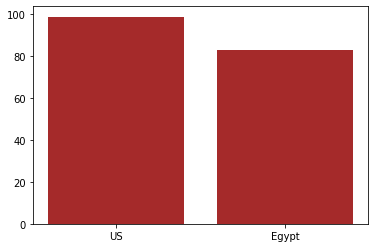

In [27]:
page_load_success_data_sorted = page_load_success_data.sort_values(0, ascending=False)
# bar = plt.bar(page_load_success_data_sorted.index, page_load_success_data_sorted[0], color='green', yerr=[df.page_load_success.std()/np.sqrt(df.page_load_success.count())*1.96 for df in [us_control_clean, egypt_control_clean]])
ar = plt.bar(page_load_success_data_sorted.index, page_load_success_data_sorted[0], color='brown')
# figure(figsize=(10, 6), dpi=80)
# plt.savefig("test")
# lt.setp(bar.get_xticklabels(), rotation=30, horizontalalignment='right')
#  plt.xticks(rotation=90)

In [38]:
dns_success_data_egypt = pd.DataFrame.from_dict({
    'Default': [egypt_control_clean.default_lookup_success.mean() * 100],
    'Cloudflare': [egypt_control_clean.cloudflare_lookup_success.mean() * 100]
}, orient='index', columns=['DNS Lookup Success Rate'])
dns_success_data_egypt

,DNS Lookup Success Rate
Default,97.116624
Cloudflare,98.969072


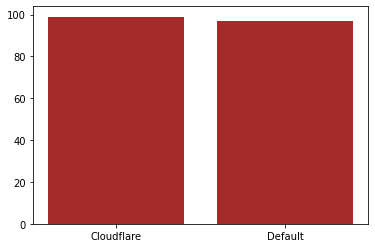

In [36]:
dns_success_data_egypt_sorted = dns_success_data_egypt.sort_values('DNS Lookup Success Rate', ascending=False)
# bar = plt.bar(page_load_success_data_sorted.index, page_load_success_data_sorted[0], color='green', yerr=[df.page_load_success.std()/np.sqrt(df.page_load_success.count())*1.96 for df in [us_control_clean, egypt_control_clean]])
bar = plt.bar(dns_success_data_egypt_sorted.index, dns_success_data_egypt_sorted['DNS Lookup Success Rate'], color='brown')

In [37]:
dns_success_data_us = pd.DataFrame.from_dict({
    'Default': [us_control_clean.default_lookup_success.mean() * 100],
    'Cloudflare': [us_control_clean.cloudflare_lookup_success.mean() * 100]
}, orient='index', columns=['DNS Lookup Success Rate'])
dns_success_data_us

,DNS Lookup Success Rate
Default,98.972724
Cloudflare,98.913685


In [74]:
# Blocked websites
egypt_failed = egypt_control_clean[egypt_control_clean.page_load_success == 0]
egypt_succeeded = egypt_control_clean[egypt_control_clean.page_load_success == 1]
us_failed = us_control_clean[us_control_clean.page_load_success == 0]
us_succeeded = us_control_clean[us_control_clean.page_load_success == 1]
egypt_blocked = egypt_failed[~(egypt_failed.url.isin(us_failed.url))]
blocked_urls = egypt_blocked.url.unique()
blocked_domains = list(set(['.'.join(urlparse(url).netloc.split('.')[1:]) if urlparse(url).netloc.split('.')[0] == 'www' else urlparse(url).netloc for url in blocked_urls]))
with open("blocked_urls.txt", "w") as f:
    f.write('\n'.join(blocked_urls))
with open("blocked_domains.txt", "w") as f:
    f.write("\n".join(blocked_domains))

In [105]:
blocked_domains_with_www = blocked_domains + ['www.' + domain for domain in blocked_domains]
bad_traffic_data = pd.read_csv("../data_collection/bad_traffic_domains.txt", header=None)
bad_traffic_data_without_www = set(['.'.join(domain.split('.')[1:]) if domain.split('.')[0] == 'www' else domain for domain in bad_traffic_data[0]])
ooni_data = pd.read_csv("../data_collection/ooni_urls.csv")
ooni_urls = list(ooni_data.url)
ooni_domains = list(set(['.'.join(urlparse(url).netloc.split('.')[1:]) if urlparse(url).netloc.split('.')[0] == 'www' else urlparse(url).netloc for url in ooni_urls]))
bad_traffic_urls = ['http://' + domain for domain in bad_traffic_data[0]]
new_urls = list(set(blocked_urls) - set(ooni_urls) - set(bad_traffic_urls))
with open("new_urls.txt", "w") as f:
    f.write("\n".join(new_urls))

In [115]:
potential_dns_poisoning = egypt_control_clean[((egypt_control_clean.default_lookup_success == 0) & (egypt_control_clean.cloudflare_lookup_success == 1))]
potential_dns_poisoning_domains = potential_dns_poisoning.domain.unique()
broken_dns_us = us_control_clean[(us_control_clean.domain.isin(potential_dns_poisoning_domains) & (us_control_clean.cloudflare_lookup_success == 0))]
dns_poisoned = potential_dns_poisoning[~(potential_dns_poisoning.domain.isin(broken_dns_us.domain))]
dns_poisoned_domains = dns_poisoned.domain.unique()
print(len(dns_poisoned_domains))
with open("dns_poisoned_domains.txt", "w") as f:
    f.write('\n'.join(dns_poisoned_domains))
dns_poisoned

37


,experiment_id,run_number,policy,domain,url,experiment_count,experiment_code,timestamp,timezone_offset,local_time,default_dns_servers,default_lookup_status,default_lookup_success,default_lookup_ips,cloudflare_lookup_status,cloudflare_lookup_success,cloudflare_lookup_ips,all_ips,page_load_success,page_load_status
21,21,0,egypt_control,balkans.aljazeera.net,http://balkans.aljazeera.net,0,balkans.aljazeera.net_0,1616234214828,-120,"3/20/2021, 11:56:54 AM","[""172.23.176.1""]",queryA ENODATA balkans.aljazeera.net,0,[],success,1,"[""23.60.215.128""]","[""23.60.215.128""]",0,net::ERR_NAME_NOT_RESOLVED at http://balkans.a...
22,22,0,egypt_control,blogs.aljazeera.net,http://blogs.aljazeera.net,0,blogs.aljazeera.net_0,1616234219812,-120,"3/20/2021, 11:56:59 AM","[""172.23.176.1""]",queryA ENODATA blogs.aljazeera.net,0,[],success,1,"[""23.60.215.128""]","[""23.60.215.128""]",0,net::ERR_NAME_NOT_RESOLVED at http://blogs.alj...
26,26,0,egypt_control,doc.aljazeera.net,http://doc.aljazeera.net,0,doc.aljazeera.net_0,1616234300330,-120,"3/20/2021, 11:58:20 AM","[""172.23.176.1""]",queryA ENODATA doc.aljazeera.net,0,[],success,1,"[""23.60.215.128""]","[""23.60.215.128""]",0,net::ERR_NAME_NOT_RESOLVED at http://doc.aljaz...
42,42,0,egypt_control,ikhwanonline.com,http://ikhwanonline.com,0,ikhwanonline.com_0,1616234537301,-120,"3/20/2021, 12:02:17 PM","[""172.23.176.1""]",queryA ENODATA ikhwanonline.com,0,[],success,1,"[""104.21.88.190"",""172.67.152.47""]","[""104.21.88.190"",""172.67.152.47""]",0,net::ERR_NAME_NOT_RESOLVED at http://ikhwanonl...
43,43,0,egypt_control,ikhwanonline.info,http://ikhwanonline.info,0,ikhwanonline.info_0,1616234542067,-120,"3/20/2021, 12:02:22 PM","[""172.23.176.1""]",queryA ENODATA ikhwanonline.info,0,[],success,1,"[""104.21.76.16"",""172.67.185.16""]","[""104.21.76.16"",""172.67.185.16""]",0,net::ERR_NAME_NOT_RESOLVED at http://ikhwanonl...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6213,5898,3,egypt_control,cluw.org,http://cluw.org/,0,cluw.org_0,1616497343568,-120,"3/23/2021, 1:02:23 PM","[""172.30.48.1""]",queryA ESERVFAIL cluw.org,0,[],success,1,"[""69.64.226.226""]","[""69.64.226.226""]",0,net::ERR_NAME_NOT_RESOLVED at http://cluw.org/
6351,6036,3,egypt_control,alaraby.co.uk,https://www.alaraby.co.uk/,14,alaraby.co.uk_14,1616499934310,-120,"3/23/2021, 1:45:34 PM","[""172.30.48.1""]",queryA ENODATA alaraby.co.uk,0,[],success,1,"[""152.195.39.175""]","[""152.195.39.175""]",0,net::ERR_NAME_NOT_RESOLVED at https://www.alar...
6431,6116,3,egypt_control,arab48.com,https://www.arab48.com/,11,arab48.com_11,1616501411389,-120,"3/23/2021, 2:10:11 PM","[""172.30.48.1""]",queryA ENODATA arab48.com,0,[],success,1,"[""52.218.240.107""]","[""52.218.240.107""]",0,net::ERR_NAME_NOT_RESOLVED at https://www.arab...
6461,6146,3,egypt_control,ikhwanonline.info,https://ikhwanonline.info/,13,ikhwanonline.info_13,1616502109087,-120,"3/23/2021, 2:21:49 PM","[""172.30.48.1""]",queryA ENODATA ikhwanonline.info,0,[],success,1,"[""104.21.76.16"",""172.67.185.16""]","[""104.21.76.16"",""172.67.185.16""]",0,net::ERR_NAME_NOT_RESOLVED at https://ikhwanon...


In [19]:
potential_blocked = egypt_control_clean[(egypt_control_clean.page_load_success == 0)]
potential_rst = potential_blocked[(potential_blocked.page_load_status.str.startswith('net::ERR_CONNECTION_RESET'))]
potential_rst.experiment_code.unique()

array(['ahmedgamalziada.blogspot.com.eg_0', 'alarab.qa_0', 'alaraby.tv_0',
       'almesryoon.com_0', 'elsharq.web.tv_0', 'fakartany.com_0',
       'hrw.org_0', 'madamasr.com_2', 'qalyubiagate.com_0',
       'sasapost.com_0', 'turk.life_0', 'alscene.com_0', 'al-watan.com_0',
       'amlalommah.net_1', 'ansarportsaed.com_1', 'arabsolaa.com_0',
       'cairoportal.com_1', 'dailysabah.com_0', 'elshaab.org_0',
       'essada.net_0', 'jatoeg.org_0', 'korabia.com_0', 'manalaa.net_0',
       'masrmix.com_0', 'moheet.com_0', 'huffpost.com_0',
       'vvv.almanassa.net_0', 'mada23.appspot.com_0',
       'mada22.appspot.com_0', 'mada21.appspot.com_0',
       'madamirror20.appspot.com_0', 'madamirror18.appspot.com_0',
       'madamirror17.appspot.com_0', 'madamirror16.appspot.com_0',
       'madamirror15.appspot.com_0', 'madamirror14.appspot.com_0',
       'madamirror13.appspot.com_0', 'madamirror12.appspot.com_0',
       'madamirror10.appspot.com_0', 'madamirror9.appspot.com_0',
       'madamirr

In [20]:
empty_resp = potential_blocked[potential_blocked.page_load_status.str.startswith('net::ERR_EMPTY_RESPONSE')]
len(empty_resp.url.unique())
empty_resp[empty_resp.run_number == 3]

,experiment_id,run_number,policy,domain,url,experiment_count,experiment_code,timestamp,timezone_offset,local_time,default_dns_servers,default_lookup_status,default_lookup_success,default_lookup_ips,cloudflare_lookup_status,cloudflare_lookup_success,cloudflare_lookup_ips,all_ips,page_load_success,page_load_status
3301,2986,3,egypt_control,gulf-times.com,http://www.gulf-times.com,12,gulf-times.com_12,1616439826965,-120,"3/22/2021, 9:03:46 PM","[""172.30.48.1""]",success,1,"[""172.67.73.97"",""104.26.14.251"",""104.26.15.251""]",success,1,"[""104.26.14.251"",""104.26.15.251"",""172.67.73.97""]","[""172.67.73.97"",""104.26.14.251"",""104.26.15.251""]",0,net::ERR_EMPTY_RESPONSE at http://www.gulf-tim...
3392,3077,3,egypt_control,turkpress.co,http://turkpress.co/,21,turkpress.co_21,1616441507533,-120,"3/22/2021, 9:31:47 PM","[""172.30.48.1""]",success,1,"[""104.26.4.116"",""172.67.69.181"",""104.26.5.116""]",success,1,"[""172.67.69.181"",""104.26.5.116"",""104.26.4.116""]","[""104.26.4.116"",""172.67.69.181"",""104.26.5.116""]",0,net::ERR_EMPTY_RESPONSE at http://turkpress.co/
3557,3242,3,egypt_control,alarab.qa,http://alarab.qa,23,alarab.qa_23,1616444648966,-120,"3/22/2021, 10:24:08 PM","[""172.30.48.1""]",success,1,"[""104.26.2.15"",""172.67.70.195"",""104.26.3.15""]",success,1,"[""172.67.70.195"",""104.26.2.15"",""104.26.3.15""]","[""104.26.2.15"",""172.67.70.195"",""104.26.3.15""]",0,net::ERR_EMPTY_RESPONSE at http://alarab.qa
3577,3262,3,egypt_control,marsadpress.net,http://marsadpress.net,21,marsadpress.net_21,1616444983037,-120,"3/22/2021, 10:29:43 PM","[""172.30.48.1""]",success,1,"[""217.160.0.60""]",success,1,"[""217.160.0.60""]","[""217.160.0.60""]",0,net::ERR_EMPTY_RESPONSE at http://marsadpress.net
3698,3383,3,egypt_control,egybest.bid,http://egybest.bid,0,egybest.bid_0,1616447242188,-120,"3/22/2021, 11:07:22 PM","[""172.30.48.1""]",success,1,"[""172.67.192.81"",""104.21.36.101""]",success,1,"[""104.21.36.101"",""172.67.192.81""]","[""172.67.192.81"",""104.21.36.101""]",0,net::ERR_EMPTY_RESPONSE at http://egybest.bid
3713,3398,3,egypt_control,masreiat.com,http://masreiat.com/,12,masreiat.com_12,1616447587255,-120,"3/22/2021, 11:13:07 PM","[""172.30.48.1""]",success,1,"[""104.21.54.14"",""172.67.222.53""]",success,1,"[""104.21.54.14"",""172.67.222.53""]","[""104.21.54.14"",""172.67.222.53""]",0,net::ERR_EMPTY_RESPONSE at http://masreiat.com/
3725,3410,3,egypt_control,cima4up.co,http://cima4up.co/%D9%85%D8%B2%D9%8A%D9%83%D8%...,11,cima4up.co_11,1616447921681,-120,"3/22/2021, 11:18:41 PM","[""172.30.48.1""]",success,1,"[""104.21.235.3"",""104.21.235.4""]",success,1,"[""104.21.235.3"",""104.21.235.4""]","[""104.21.235.3"",""104.21.235.4""]",0,net::ERR_EMPTY_RESPONSE at http://cima4up.co/%...
3744,3429,3,egypt_control,almesryoon.com,http://almesryoon.com,21,almesryoon.com_21,1616448226941,-120,"3/22/2021, 11:23:46 PM","[""172.30.48.1""]",success,1,"[""104.21.52.44"",""172.67.195.19""]",success,1,"[""172.67.195.19"",""104.21.52.44""]","[""104.21.52.44"",""172.67.195.19""]",0,net::ERR_EMPTY_RESPONSE at http://almesryoon.com
3759,3444,3,egypt_control,raya.com,http://raya.com/,15,raya.com_15,1616448465144,-120,"3/22/2021, 11:27:45 PM","[""172.30.48.1""]",success,1,"[""172.67.74.185"",""104.26.11.92"",""104.26.10.92""]",success,1,"[""104.26.11.92"",""104.26.10.92"",""172.67.74.185""]","[""172.67.74.185"",""104.26.11.92"",""104.26.10.92""]",0,net::ERR_EMPTY_RESPONSE at http://raya.com/
3766,3451,3,egypt_control,elwehda.com,http://www.elwehda.com,21,elwehda.com_21,1616448585384,-120,"3/22/2021, 11:29:45 PM","[""172.30.48.1""]",success,1,"[""172.67.139.223"",""104.21.65.27""]",success,1,"[""104.21.65.27"",""172.67.139.223""]","[""172.67.139.223"",""104.21.65.27""]",0,net::ERR_EMPTY_RESPONSE at http://www.elwehda.com


In [21]:
connection_refused = potential_blocked[potential_blocked.page_load_status.str.startswith('net::ERR_CONNECTION_REFUSED')]
connection_refused

,experiment_id,run_number,policy,domain,url,experiment_count,experiment_code,timestamp,timezone_offset,local_time,default_dns_servers,default_lookup_status,default_lookup_success,default_lookup_ips,cloudflare_lookup_status,cloudflare_lookup_success,cloudflare_lookup_ips,all_ips,page_load_success,page_load_status
25,25,0,egypt_control,dailynewsegypt.com,http://dailynewsegypt.com,0,dailynewsegypt.com_0,1616234294264,-120,"3/20/2021, 11:58:14 AM","[""172.23.176.1""]",success,1,"[""151.139.243.1""]",success,1,"[""151.139.243.1""]","[""151.139.243.1""]",0,net::ERR_CONNECTION_REFUSED at http://dailynew...
1029,714,1,egypt_control,cencos.org,http://cencos.org/,10,cencos.org_10,1616314116152,-120,"3/21/2021, 10:08:36 AM","[""172.23.176.1""]",success,1,"[""159.203.8.241""]",success,1,"[""159.203.8.241""]","[""159.203.8.241""]",0,net::ERR_CONNECTION_REFUSED at http://cencos.org/
3337,3022,3,egypt_control,cencos.org,http://cencos.org/,11,cencos.org_11,1616440379897,-120,"3/22/2021, 9:12:59 PM","[""172.30.48.1""]",success,1,"[""159.203.8.241""]",success,1,"[""159.203.8.241""]","[""159.203.8.241""]",0,net::ERR_CONNECTION_REFUSED at http://cencos.org/
3739,3424,3,egypt_control,madamirror18.appspot.com,https://madamirror18.appspot.com/www.madamasr....,0,madamirror18.appspot.com_0,1616448145838,-120,"3/22/2021, 11:22:25 PM","[""172.30.48.1""]",success,1,"[""172.217.18.244""]",success,1,"[""216.58.198.84""]","[""172.217.18.244"",""216.58.198.84""]",0,net::ERR_CONNECTION_REFUSED at https://madamir...
3923,3608,3,egypt_control,jiameng.com,http://jiameng.com,0,jiameng.com_0,1616451498863,-120,"3/23/2021, 12:18:18 AM","[""172.30.48.1""]",success,1,"[""127.0.0.1""]",success,1,"[""127.0.0.1""]","[""127.0.0.1""]",0,net::ERR_CONNECTION_REFUSED at http://jiameng.com
4140,3825,3,egypt_control,payu.in,http://payu.in,0,payu.in_0,1616455500989,-120,"3/23/2021, 1:25:00 AM","[""172.30.48.1""]",success,1,"[""65.1.34.99"",""13.232.230.23""]",success,1,"[""13.232.230.23"",""65.1.34.99""]","[""65.1.34.99"",""13.232.230.23""]",0,net::ERR_CONNECTION_REFUSED at http://payu.in
4467,4152,3,egypt_control,toolur.com,http://www.toolur.com,21,toolur.com_21,1616462935640,-120,"3/23/2021, 3:28:55 AM","[""172.30.48.1""]",success,1,"[""195.201.209.26""]",success,1,"[""195.201.209.26""]","[""195.201.209.26""]",0,net::ERR_CONNECTION_REFUSED at http://www.tool...
4481,4166,3,egypt_control,toolur.com,http://www.toolur.com/,22,toolur.com_22,1616463226412,-120,"3/23/2021, 3:33:46 AM","[""172.30.48.1""]",success,1,"[""195.201.209.26""]",success,1,"[""195.201.209.26""]","[""195.201.209.26""]",0,net::ERR_CONNECTION_REFUSED at http://www.tool...
6472,6157,3,egypt_control,myworkdayjobs.com,http://myworkdayjobs.com,0,myworkdayjobs.com_0,1616502320389,-120,"3/23/2021, 2:25:20 PM","[""172.30.48.1""]",success,1,"[""127.0.0.1""]",success,1,"[""127.0.0.1""]","[""127.0.0.1""]",0,net::ERR_CONNECTION_REFUSED at http://myworkda...


In [22]:
address_unreachable = potential_blocked[potential_blocked.page_load_status.str.startswith('net::ERR_ADDRESS_UNREACHABLE')]
address_unreachable

,experiment_id,run_number,policy,domain,url,experiment_count,experiment_code,timestamp,timezone_offset,local_time,default_dns_servers,default_lookup_status,default_lookup_success,default_lookup_ips,cloudflare_lookup_status,cloudflare_lookup_success,cloudflare_lookup_ips,all_ips,page_load_success,page_load_status
115,115,0,egypt_control,activewebproxy.cf,http://www.activewebproxy.cf,0,activewebproxy.cf_0,1616235700865,-120,"3/20/2021, 12:21:40 PM","[""172.23.176.1""]",success,1,"[""195.20.51.56""]",success,1,"[""195.20.51.56""]","[""195.20.51.56""]",0,net::ERR_ADDRESS_UNREACHABLE at http://www.act...
159,159,0,egypt_control,bypasstool.gq,http://www.bypasstool.gq,0,bypasstool.gq_0,1616236367310,-120,"3/20/2021, 12:32:47 PM","[""172.23.176.1""]",success,1,"[""195.20.50.134""]",success,1,"[""195.20.50.134""]","[""195.20.50.134""]",0,net::ERR_ADDRESS_UNREACHABLE at http://www.byp...
2721,2406,2,egypt_control,topnewproxy.gq,http://www.topnewproxy.gq,20,topnewproxy.gq_20,1616354052613,-120,"3/21/2021, 9:14:12 PM","[""172.22.160.1""]",success,1,"[""195.20.48.217""]",success,1,"[""195.20.48.217""]","[""195.20.48.217""]",0,net::ERR_ADDRESS_UNREACHABLE at http://www.top...
3540,3225,3,egypt_control,freshfreeproxy.ga,http://www.freshfreeproxy.ga,21,freshfreeproxy.ga_21,1616444243547,-120,"3/22/2021, 10:17:23 PM","[""172.30.48.1""]",success,1,"[""195.20.54.104""]",success,1,"[""195.20.54.104""]","[""195.20.54.104""]",0,net::ERR_ADDRESS_UNREACHABLE at http://www.fre...
4659,4344,3,egypt_control,akproxy.gq,http://www.akproxy.gq,21,akproxy.gq_21,1616466884975,-120,"3/23/2021, 4:34:44 AM","[""172.30.48.1""]",success,1,"[""195.20.52.148""]",success,1,"[""195.20.52.148""]","[""195.20.52.148""]",0,net::ERR_ADDRESS_UNREACHABLE at http://www.akp...
5550,5235,3,egypt_control,bypasstool.gq,http://bypasstool.gq/,22,bypasstool.gq_22,1616484799671,-120,"3/23/2021, 9:33:19 AM","[""172.30.48.1""]",success,1,"[""195.20.50.134""]",success,1,"[""195.20.50.134""]","[""195.20.50.134""]",0,net::ERR_ADDRESS_UNREACHABLE at http://bypasst...
6062,5747,3,egypt_control,takesper.gq,http://www.takesper.gq,22,takesper.gq_22,1616494883340,-120,"3/23/2021, 12:21:23 PM","[""172.30.48.1""]",success,1,"[""195.20.48.69""]",success,1,"[""195.20.48.69""]","[""195.20.48.69""]",0,net::ERR_ADDRESS_UNREACHABLE at http://www.tak...
6432,6117,3,egypt_control,steadyproxy.ga,http://steadyproxy.ga,21,steadyproxy.ga_21,1616501460821,-120,"3/23/2021, 2:11:00 PM","[""172.30.48.1""]",success,1,"[""195.20.52.203""]",success,1,"[""195.20.52.203""]","[""195.20.52.203""]",0,net::ERR_ADDRESS_UNREACHABLE at http://steadyp...


In [23]:
connection_closed = potential_blocked[potential_blocked.page_load_status.str.startswith('net::ERR_CONNECTION_CLOSED')]
connection_closed.experiment_code.unique()

array(['madamirror19.appspot.com_0', 'madamirror11.appspot.com_0',
       'madamirrored.appspot.com_0', 'al-sharq.com_0',
       'akhbaralsabah.com_0', 'khatab38.blogspot.com_10',
       'baheyya.blogspot.com_10', 'raseef22.com_10', 'shahidwbas.com_10',
       'eg.arblionz.com_10', 'tv.arblionz.com_10',
       'thepeninsulaqatar.com_10', 'alborsanews.com_20',
       'sasapost.com_20', 'amlalommah.net_20', 'alarab.qa_20',
       'shadowsocks.org_20', 'cdn.ampproject.org_20', 'medium.com_11',
       'baheyya.blogspot.com_11', 'shadowsocks.org_21', 'ida2at.com_22',
       'sasapost.com_22', 'madamirror16.appspot.com_0',
       'arabicpost.net_11', 'elbadil.com_12', 'mada23.appspot.com_0',
       'madamirror14.appspot.com_0', 'amlalommah.net_23',
       'cdn.ampproject.org_21', 'tunnelbear.com_24', 'halacima.net_11',
       'harmees.com_22', 'al-sharq.com_25', 'eipss-eg.org_11',
       'madamirror7.appspot.com_0', 'gamaltaha.wordpress.com_11',
       'shahidwbas.com_11', 'raseef22.com_11',

In [24]:
navigation_timeout_exceeded = potential_blocked[potential_blocked.page_load_status.str.startswith('Navigation timeout')]
navigation_timeout_exceeded_run3 = navigation_timeout_exceeded[navigation_timeout_exceeded.run_number == 3]
us_navigation_timeout = us_control_clean[us_control_clean.page_load_status.str.startswith('Navigation timeout')]
navigation_timeout_exceeded_run3[~(navigation_timeout_exceeded_run3.url.isin(us_navigation_timeout.url))]

,experiment_id,run_number,policy,domain,url,experiment_count,experiment_code,timestamp,timezone_offset,local_time,default_dns_servers,default_lookup_status,default_lookup_success,default_lookup_ips,cloudflare_lookup_status,cloudflare_lookup_success,cloudflare_lookup_ips,all_ips,page_load_success,page_load_status
3118,2803,3,egypt_control,odaily.com,http://odaily.com,0,odaily.com_0,1616436633228,-120,"3/22/2021, 8:10:33 PM","[""172.30.48.1""]",success,1,"[""39.107.149.215""]",success,1,"[""39.107.149.215""]","[""39.107.149.215""]",0,Navigation timeout of 60000 ms exceeded
3124,2809,3,egypt_control,cites.org,https://cites.org/,21,cites.org_21,1616436763288,-120,"3/22/2021, 8:12:43 PM","[""172.30.48.1""]",success,1,"[""104.22.46.86"",""104.22.47.86"",""172.67.25.202""]",success,1,"[""104.22.46.86"",""104.22.47.86"",""172.67.25.202""]","[""104.22.46.86"",""104.22.47.86"",""172.67.25.202""]",0,Navigation timeout of 60000 ms exceeded
3147,2832,3,egypt_control,fhi360.org,https://www.fhi360.org/,21,fhi360.org_21,1616437208284,-120,"3/22/2021, 8:20:08 PM","[""172.30.48.1""]",success,1,"[""23.185.0.3""]",success,1,"[""23.185.0.3""]","[""23.185.0.3""]",0,Navigation timeout of 60000 ms exceeded
3153,2838,3,egypt_control,anonymous-proxy-servers.net,http://anonymous-proxy-servers.net/,0,anonymous-proxy-servers.net_0,1616437332433,-120,"3/22/2021, 8:22:12 PM","[""172.30.48.1""]",success,1,"[""78.129.207.59""]",success,1,"[""78.129.207.59""]","[""78.129.207.59""]",0,Navigation timeout of 60000 ms exceeded
3158,2843,3,egypt_control,childrensdefense.org,http://www.childrensdefense.org/,21,childrensdefense.org_21,1616437446358,-120,"3/22/2021, 8:24:06 PM","[""172.30.48.1""]",success,1,"[""50.115.17.19""]",success,1,"[""50.115.17.19""]","[""50.115.17.19""]",0,Navigation timeout of 60000 ms exceeded
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6448,6133,3,egypt_control,setn.com,http://setn.com,0,setn.com_0,1616501818519,-120,"3/23/2021, 2:16:58 PM","[""172.30.48.1""]",success,1,"[""54.238.119.86""]",success,1,"[""54.238.119.86""]","[""54.238.119.86""]",0,Navigation timeout of 60000 ms exceeded
6466,6151,3,egypt_control,ozon.ru,http://ozon.ru,0,ozon.ru_0,1616502188933,-120,"3/23/2021, 2:23:08 PM","[""172.30.48.1""]",success,1,"[""45.60.40.164"",""45.60.34.164""]",success,1,"[""45.60.34.164"",""45.60.40.164""]","[""45.60.40.164"",""45.60.34.164""]",0,Navigation timeout of 60000 ms exceeded
6476,6161,3,egypt_control,alahlynet.com.eg,http://alahlynet.com.eg,0,alahlynet.com.eg_0,1616502372180,-120,"3/23/2021, 2:26:12 PM","[""172.30.48.1""]",success,1,"[""41.33.192.20""]",success,1,"[""41.33.192.20""]","[""41.33.192.20""]",0,Navigation timeout of 60000 ms exceeded
6489,6174,3,egypt_control,eluniversal.com,http://www.eluniversal.com/,21,eluniversal.com_21,1616502633577,-120,"3/23/2021, 2:30:33 PM","[""172.30.48.1""]",success,1,"[""144.217.180.146""]",success,1,"[""144.217.180.146""]","[""144.217.180.146""]",0,Navigation timeout of 60000 ms exceeded


In [25]:
timeout = potential_blocked[potential_blocked.page_load_status.str.startswith('net::ERR_TIMED_OUT')]
timeout.experiment_code

3139                    opera.com_21
3210                  manalaa.net_12
3218              arab-turkey.com_21
3367                     hamas.ps_13
3391               tunnelbear.com_23
3471                         ok.ru_0
3505              genderation.xyz_11
3538                  tigervpn.com_0
3643                aljazeera.com_13
3687                hidemyass.com_22
3743                   mormon.org_21
3760                     hola.org_23
3819                    turk.life_23
3855                 alalamtv.net_11
3860             vvv.almanassa.net_0
3910                   alhurra.com_0
3940                usacasino.com_21
3956                 ipvanish.com_22
3961                securevpn.com_21
3966                 f-secure.com_21
4034    privateinternetaccess.com_21
4078               online.wsj.com_21
4135             vwv.almanassa.net_0
4494               tunnelbear.com_25
4669                    katib.net_11
4690                shahidlive.co_11
4702     reporter-ohne-grenzen.de_22
4

In [26]:
cert_date_invalid = potential_blocked[potential_blocked.page_load_status.str.startswith('net::ERR_CERT_DATE_INVALID')]
cert_date_invalid

,experiment_id,run_number,policy,domain,url,experiment_count,experiment_code,timestamp,timezone_offset,local_time,default_dns_servers,default_lookup_status,default_lookup_success,default_lookup_ips,cloudflare_lookup_status,cloudflare_lookup_success,cloudflare_lookup_ips,all_ips,page_load_success,page_load_status
3600,3285,3,egypt_control,kickstarter.com,http://kickstarter.com,0,kickstarter.com_0,1616445334801,-120,"3/22/2021, 10:35:34 PM","[""172.30.48.1""]",success,1,"[""151.101.2.217"",""151.101.66.217"",""151.101.130...",success,1,"[""151.101.66.217"",""151.101.194.217"",""151.101.1...","[""151.101.2.217"",""151.101.66.217"",""151.101.130...",0,net::ERR_CERT_DATE_INVALID at http://kickstart...


In [27]:
too_many_redirects = potential_blocked[potential_blocked.page_load_status.str.startswith('net::ERR_TOO_MANY_REDIRECTS')]
too_many_redirects

,experiment_id,run_number,policy,domain,url,experiment_count,experiment_code,timestamp,timezone_offset,local_time,default_dns_servers,default_lookup_status,default_lookup_success,default_lookup_ips,cloudflare_lookup_status,cloudflare_lookup_success,cloudflare_lookup_ips,all_ips,page_load_success,page_load_status
4333,4018,3,egypt_control,state.gov,https://www.state.gov/j/drl/,23,state.gov_23,1616459879718,-120,"3/23/2021, 2:37:59 AM","[""172.30.48.1""]",success,1,"[""34.233.79.178""]",success,1,"[""34.233.79.178""]","[""34.233.79.178""]",0,net::ERR_TOO_MANY_REDIRECTS at https://www.sta...


In [28]:
aborted = potential_blocked[potential_blocked.page_load_status.str.startswith('net::ERR_ABORTED')]
us_control_clean[us_control_clean.domain == 'denetsuk.com']

,experiment_id,run_number,policy,domain,url,experiment_count,experiment_code,timestamp,timezone_offset,local_time,default_dns_servers,default_lookup_status,default_lookup_success,default_lookup_ips,cloudflare_lookup_status,cloudflare_lookup_success,cloudflare_lookup_ips,all_ips,page_load_success,page_load_status
7418,7605,26,us_control,denetsuk.com,http://denetsuk.com,0,denetsuk.com_0,1616469105823,240,"3/22/2021, 11:11:45 PM","[""172.27.64.1""]",success,1,"[""139.45.197.101"",""139.45.197.90""]",success,1,"[""139.45.197.101"",""139.45.197.90""]","[""139.45.197.101"",""139.45.197.90""]",0,net::ERR_ABORTED at http://denetsuk.com


In [29]:
cert_name_invalid = potential_blocked[potential_blocked.page_load_status.str.startswith('net::ERR_CERT_COMMON_NAME_INVALID')]
us_control_clean[us_control_clean.domain == 'khales.com.eg']

,experiment_id,run_number,policy,domain,url,experiment_count,experiment_code,timestamp,timezone_offset,local_time,default_dns_servers,default_lookup_status,default_lookup_success,default_lookup_ips,cloudflare_lookup_status,cloudflare_lookup_success,cloudflare_lookup_ips,all_ips,page_load_success,page_load_status
8462,8649,26,us_control,khales.com.eg,http://khales.com.eg,0,khales.com.eg_0,1616483200078,240,"3/23/2021, 3:06:40 AM","[""172.27.64.1""]",success,1,"[""196.46.22.61""]",success,1,"[""196.46.22.61""]","[""196.46.22.61""]",0,net::ERR_CERT_COMMON_NAME_INVALID at http://kh...


In [30]:
nonblocked_domains = egypt_control_clean[((egypt_control_clean.page_load_success == 1) & ~(egypt_control_clean.url.isin(potential_blocked.url)) & (egypt_control_clean.default_lookup_success == 1) & ~(egypt_control_clean.domain.isin(dns_poisoned_domains)))]
nonblocked_domains.describe()

,experiment_id,run_number,experiment_count,timestamp,timezone_offset,default_lookup_success,cloudflare_lookup_success,page_load_success
count,4853.000000,4853.000000,4853.000000,4.853000e+03,4853.0,4853.0,4853.0,4853.0
mean,3110.267257,2.369668,15.120956,1.616407e+12,-120.0,1.0,1.0,1.0
std,1824.429394,0.865765,8.527295,7.464248e+07,0.0,0.0,0.0,0.0
min,2.000000,0.000000,0.000000,1.616234e+12,-120.0,1.0,1.0,1.0
25%,1516.000000,2.000000,10.000000,1.616338e+12,-120.0,1.0,1.0,1.0
50%,3171.000000,3.000000,20.000000,1.616443e+12,-120.0,1.0,1.0,1.0
75%,4710.000000,3.000000,21.000000,1.616474e+12,-120.0,1.0,1.0,1.0
max,6197.000000,3.000000,32.000000,1.616503e+12,-120.0,1.0,1.0,1.0


In [137]:
egypt_failed = egypt_control_clean[egypt_control_clean.page_load_success == 0]
egypt_failed.describe()

,experiment_id,run_number,experiment_count,timestamp,timezone_offset,default_lookup_success,cloudflare_lookup_success,page_load_success,conn_rst,name_not_resolved,...,empty_response,connection_closed,connection_refused,too_many_redirects,cert_date_invalid,aborted,cert_name_invalid,rst,dropped,dns_poison
count,1078.000000,1078.000000,1078.000000,1.078000e+03,1078.0,1078.000000,1078.000000,1078.0,1078.000000,1078.000000,...,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000
mean,2803.102968,2.060297,11.562152,1.616392e+12,-120.0,0.873840,0.978664,0.0,0.232839,0.128015,...,0.092764,0.054731,0.008349,0.000928,0.000928,0.000928,0.000928,0.241187,0.617811,0.128015
std,1967.841806,1.162347,9.122978,8.662137e+07,0.0,0.332183,0.144568,0.0,0.422836,0.334261,...,0.290237,0.227560,0.091032,0.030457,0.030457,0.030457,0.030457,0.428002,0.486148,0.334261
min,0.000000,0.000000,0.000000,1.616234e+12,-120.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,703.250000,1.000000,0.000000,1.616314e+12,-120.0,1.000000,1.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2923.000000,3.000000,11.000000,1.616439e+12,-120.0,1.000000,1.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,4477.750000,3.000000,21.000000,1.616469e+12,-120.0,1.000000,1.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,6187.000000,3.000000,26.000000,1.616503e+12,-120.0,1.000000,1.000000,0.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [205]:
errors = 'conn_rst name_not_resolved address_unreachable timed_out navigation_timeout empty_response connection_closed connection_refused'.split()
labels = {
    'conn_rst': 'Connection Reset',
    'name_not_resolved': 'Name not Resolved',
    'address_unreachable': "Address Unreachable",
    'timed_out': "Connection Timed Out",
    'navigation_timeout': "Navigation Timeout",
    'empty_response': "Empty Response",
    'connection_closed': "Connection Closed",
    'connection_refused': "Connection Refused"
}
error_data_dict = {}
for error in errors:
    error_data_dict[labels[error]] = {
        'count': egypt_failed[egypt_failed[error] == 1][error].count(),
        'percentage': egypt_failed[error].mean() * 100,
    }
error_data = pd.DataFrame.from_dict(error_data_dict, orient='index').sort_values('count', ascending=False)

total_count = error_data['count'].sum()
total_percentage = error_data.percentage.sum()
new_row = {
    'Total': {
        'count': total_count,
        'percentage': total_percentage
    }
}
error_data = error_data.append(pd.DataFrame.from_dict(new_row, orient='index'))
error_data


,count,percentage
Navigation Timeout,450,41.743970
Connection Reset,251,23.283859
Name not Resolved,138,12.801484
Empty Response,100,9.276438
Connection Closed,59,5.473098
Connection Timed Out,48,4.452690
Connection Refused,9,0.834879
Address Unreachable,8,0.742115
Total,1063,98.608534


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

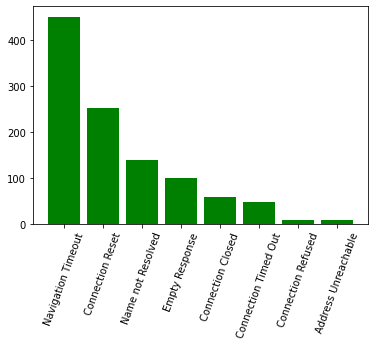

In [190]:
bar = plt.bar([x for x in error_data.index if x != 'Total'], error_data.loc['Navigation Timeout':,'count'], color='green')
plt.xticks(rotation=70)

In [32]:
# Generate list of domains
normal_sample = list(nonblocked_domains.sample(n=30).url)
dns_poisoned_sample = list(dns_poisoned.sample(n=30).url)
rst_packet_sample = list(potential_rst.sample(n=30).url)
empty_rsp_sample = list(empty_resp.sample(n=30).url)
conn_closed_sample = list(connection_closed.sample(n=30).url)
timed_out_sample = list(timeout.sample(n=30).url)
conn_refused_urls = list(connection_refused.url)
address_unreachable_urls = list(address_unreachable.url)
cert_date_invalid_url = list(cert_date_invalid.url)
too_many_redirects_url = list(too_many_redirects.url)
sample_urls = list(set(normal_sample + dns_poisoned_sample + rst_packet_sample + empty_rsp_sample + conn_closed_sample + timed_out_sample + conn_refused_urls + address_unreachable_urls + cert_date_invalid_url + too_many_redirects_url))

In [33]:
len(sample_urls)
sample_urls
# with open("./../data_collection/sample_urls.txt", "w") as f:
#     f.write('\n'.join(sample_urls))

['http://www.sex.com/',
 'http://www.matrimony.org/',
 'http://cima4up.co/%D9%85%D8%B2%D9%8A%D9%83%D8%A7-%D8%AA%D9%88-%D8%AF%D8%A7%D9%89-mazika2day/',
 'http://www.akproxy.gq',
 'http://www.inminds.co.uk/',
 'https://amlalommah.net/',
 'http://madamasr.com',
 'http://www.vpntool.com/',
 'https://surfshark.com/',
 'http://alarab.qa',
 'https://manalaa.net/',
 'https://cyberghostvpn.com/',
 'http://mubasher.aljazeera.net',
 'http://turk.life',
 'https://www.raya.com/portal',
 'https://madamirrorreloaded.appspot.com/www.madamasr.com/',
 'http://institute.aljazeera.net',
 'https://www.alborsanews.com/',
 'http://www.circumcision.org/',
 'http://www.masr11.com',
 'https://www.aljazeera.net/portal',
 'http://www.alarab.qa',
 'http://sasapost.com',
 'http://marsadpress.net',
 'http://www.poker.com/',
 'https://getintra.org/',
 'http://dailynewsegypt.com',
 'http://www.al-watan.com',
 'http://www.thepeninsulaqatar.com',
 'https://www.al-akhbar.com/',
 'http://www.essada.net',
 'https://blogs.a